In [1]:
debug = False  # Faster version for code testing
predicted_feature = 'PreciseYrs'  # Can be 'PreciseYrs', 'PDS', 'meanT'
subset_age_group = 'adults_only'  # can be 'children_only', 'adults_only', 'all'

# Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotnine as gg
gg.theme_set(gg.theme_classic)
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures
# from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.compose import TransformedTargetRegressor

In [3]:
from Functions import get_ages_cols, name_from_index, get_param_names, get_category_dict, get_category_from_feature, \
RepeatableGridSearchCV, make_gridder_pd

## Directories etc.

In [4]:
data_save_path = "C:/Users/maria/MEGAsync/SLCNdata/Meta/all_data"
plot_save_path = "C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots"
if not os.path.exists(plot_save_path):
    os.makedirs(plot_save_path)

In [5]:
gridder_source = 'make'
gridder_path = os.path.join(data_save_path, 'all_gridders_{}.csv'.format(predicted_feature))

# Get data

In [6]:
all_data = pd.read_csv(os.path.join(data_save_path, 'all_data.csv'), index_col=0)
all_data_z = pd.read_csv(os.path.join(data_save_path, 'all_data_z.csv'), index_col=0)
all_data_long = pd.read_csv(os.path.join(data_save_path, 'all_data_long.csv'), index_col=0)
all_data_long_z = pd.read_csv(os.path.join(data_save_path, 'all_data_long_z.csv'), index_col=0)
# fit_pd_all = pd.read_csv(os.path.join(data_save_path, 'fit_pd_all.csv'), index_col=0)
# loadings_long_all = pd.read_csv(os.path.join(data_save_path, 'loadings_long_all.csv'), index_col=0)
ages_dir = "C:/Users/maria/MEGAsync/SLCNdata/SLCNinfo2.csv"
ages = pd.read_csv(os.path.join(ages_dir))

In [7]:
if subset_age_group == 'children_only':
    all_data = all_data.loc[all_data['PreciseYrs'] < 18]
    all_data_z = all_data_z.loc[all_data_z['PreciseYrs'] < 18]
    all_data_long = all_data_long.loc[all_data_long['PreciseYrs'] < 18]
    all_data_long_z = all_data_long_z.loc[all_data_long_z['PreciseYrs'] < 18]
    ages = ages.loc[ages['PreciseYrs'] < 18]
elif subset_age_group == 'adults_only':
    all_data = all_data.loc[all_data['PreciseYrs'] >= 18]
    all_data_z = all_data_z.loc[all_data_z['PreciseYrs'] >= 18]
    all_data_long = all_data_long.loc[all_data_long['PreciseYrs'] >= 18]
    all_data_long_z = all_data_long_z.loc[all_data_long_z['PreciseYrs'] >= 18]
    ages = ages.loc[ages['PreciseYrs'] >= 18]
elif subset_age_group == 'all':
    pass
else:
    raise ValueError('Variable "subset_age_group" must be one of "children_only", "adults_only", or "all"')

In [8]:
# param_cols = list(set([c for c in all_data.columns for p in get_param_names() if p in c]))
ages_cols = get_ages_cols()
param_names = get_param_names()
category_dict = get_category_dict()

# Sources
https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html -> Using `TransformedTargetRegressor` to get coefficients while doing repeated CV

## Predict age using regularized regression

### Ridge regression
* L2-norm (returns small but non-zero coefficients)
* It is majorly used to prevent overfitting. Since it includes all the features, it is not very useful in case of exorbitantly high #features, say in millions, as it will pose computational challenges.
* It generally works well even in presence of highly correlated features as it will include all of them in the model but the coefficients will be distributed among them depending on the correlation.

### Lasso regression
* L1-norm (sparse; tries to get many coefficients 0)
* It arbitrarily selects any one feature among the highly correlated ones and reduced the coefficients of the rest to zero. Also, the chosen variable changes randomly with change in model parameters. This generally doesn’t work that well as compared to ridge regression.
* Since it provides sparse solutions, it is generally the model of choice (or some variant of this concept) for modelling cases where the #features are in millions or more. In such a case, getting a sparse solution is of great computational advantage as the features with zero coefficients can simply be ignored.

### Conclusion
* Ridge might be better because of how it deals with correlated features

## Define functions to prepare regression data (raw features, polynomial features, data subsets)

In [9]:
def get_poly_regr_task(regr_X, task_name, poly_degree=2):
    
    """
    Take data of one task and add all interactions and squared features.
    """
    
    task_cols = [c for c in regr_X.columns if task_name in c]
    poly = PolynomialFeatures(poly_degree, include_bias=False)
    regr_poly_task = poly.fit_transform(regr_X[task_cols])
    regr_poly_task = pd.DataFrame(regr_poly_task, columns=poly.get_feature_names(task_cols))
    regr_poly_task['sid'] = regr_X.index
    
    return regr_poly_task

# # Example use
# get_poly_regr_task(regr_X_raw, '_')  # to get ALL polynomial features
# get_poly_regr_task(regr_X_raw, 'ps_')  # to polynomial features of probswitch only

# # param_cols = [c for c in all_data_z.columns for p in param_names if p in c]

In [10]:
def get_poly_regr_data(regr_X, method):
    
    """
    Take data of all tasks and add squared features and feature interactions (but only within each task).
    """
    
    if method == 'within_tasks':
        
        task_names = ['bf_', 'ps_', 'rl_']
        poly_regr_dat = get_poly_regr_task(regr_X, task_names[0])

        for task_name in task_names[1:]:

            poly_regr_task = get_poly_regr_task(regr_X, task_name)
            poly_regr_dat = pd.merge(poly_regr_dat, poly_regr_task, on=['sid'])
        
    elif method == 'all':
        
        poly_regr_dat = get_poly_regr_task(regr_X, '_')
        
    else:
        
        raise ValueError('Method argument must be either "within_tasks" or "all".')

    poly_regr_dat = poly_regr_dat.set_index('sid')
    
    return poly_regr_dat

# # Example Use
# poly_X_all = get_poly_regr_data(regr_X_raw, 'all')
# poly_X_within = get_poly_regr_data(regr_X_raw, 'within_tasks')
# print('Number of polynomial features: {}'.format(poly_X_all.shape[1]))
# for i in range(30, 700, 30):
#     print(poly_X_all.columns[i-30:i])

In [11]:
def get_regr_data(data, data_sub, model_name, bool_pc=False, ages=None):
    
    """
    'raw': Subset data to get the data that is used in the regression model (behavioral and parameter features).
    'pc': Subset data to get data (PCs based on behavioral and parameter features).
    """
    
    # Subset columns (all, params only, behavior only)
    param_cols = list(set([c for c in data.columns for p in param_names if p in c]))
    beh_cols = list(set([c for c in data.columns if c not in param_cols]))

    if data_sub == 'all':
        sub_dat = data.copy()
    elif data_sub == 'param':
        sub_dat = data[ages_cols + param_cols]
    elif data_sub == 'beh':
        sub_dat = data[beh_cols]
    else:
        raise ValueError('data_sub must be "all", "param", or "beh".')
        
    # Take care of PC features
    if bool_pc:
        regr_dat = pd.merge(sub_dat, ages).drop(columns=[c for c in ages.columns if (c != 'ID') and (c != predicted_feature)])  # PCs
    else:
        a_cols = [a for a in ages_cols if not a in [predicted_feature, 'ID']]
        regr_dat = sub_dat[[c for c in sub_dat.columns if c not in a_cols]]  # behaviors

    # HEART: Get regr_dat, X, and y
    regr_dat = regr_dat.dropna().set_index('ID')
    regr_X = regr_dat.drop(columns=predicted_feature)
    regr_y = regr_dat[predicted_feature]
    
    # Get raw / polynomial data
    y = regr_y.copy()
    if model_name == 'raw':
        X = regr_X.copy()
    elif model_name == 'poly_all':
        X = get_poly_regr_data(regr_X, 'all')
    elif model_name == 'poly_within':
        X = get_poly_regr_data(regr_X, 'within_tasks')
    else:
        raise ValueError('model_name must be "poly_all", "poly_within", or "raw".')
    print('Number of features: {}'.format(X.shape[1]))

    return regr_dat, X, y

# # Example Use
# regr_dat, X, y = get_regr_data(all_data_z, data_sub='all', model_name='poly_all')
# regr_dat_pc, regr_X_pc, regr_y_pc = get_regr_data(fit_pd_all, data_sub='all', model_name='raw', bool_pc=True, ages=ages)

## Define functions for repeated k-fold regression

In [12]:
# class RepeatableGridSearchCV:
    
#     """ Wrapper class for GridSearchCV with RepeatedKFold.
#     """
    
#     def __init__(
#         self,
#         model,
#         parameters,
#         n_splits=20,
#         n_repeats=10,
#         random_state=None,
#         n_jobs=-1,
#         scoring=None,
#         refit=True,
#     ):
        
#         # cv or repeated cv?
#         if n_repeats == 1:
#             cv = n_splits
#         else:
#             cv = RepeatedKFold(
#                 n_splits=n_splits, n_repeats=n_repeats, random_state=random_state
#             )
        
#         # setup the grid search; done
#         gridder = GridSearchCV(
#             model, parameters, cv=cv, n_jobs=n_jobs, scoring=scoring, refit=refit
#         )
#         self._gridder = gridder
    
#     def __getattr__(self, attr):
        
#         """ Expose all attributes from GridSearchCV """
        
#         return getattr(self._gridder, attr)

In [13]:
# def make_gridder_pd(gridder):
    
#     return pd.DataFrame({
#         name: gridder.cv_results_[name]
#         for name in ['mean_test_score', 'std_test_score', 'param_alpha']  #, 'mean_train_score', 'std_train_score']
#     })

# # # Example use
# # make_gridder_pd(gridder)

In [14]:
def make_gridder_long(gridder_results):
    
    gridder_long = pd.melt(gridder_results, id_vars=['param_alpha', 'model_name', 'data_sub', 'n_splits'], var_name='score_name', value_name='score')
    gridder_long['stat'] = gridder_long['score_name'].apply(lambda x: x.split('_')[0])
#     gridder_long['train_test'] = gridder_long['score_name'].apply(lambda x: x.split('_')[1])
    
    return gridder_long

# # Example use
# make_gridder_long(all_gridders)

## Define functions for predicted ages and fitted coefficients

In [15]:
def get_poly_task(pred):
    
    if ' ' in pred:  # Interaction between two tasks
        p0, p1 = pred.split(' ')
        task = p0[:2] + '_' + p1[:2]

    elif '^2' in pred:
        task = pred[:2] + '^2'

    else:  # Just one task
        task = pred[:2]
    
    return task

# # Example use
# get_poly_task(lin_reg_result_raw_poly['predictor'][5])

In [16]:
def get_poly_pure_int_2(pred):
    
    if ' ' in pred:  # Interaction between two tasks
        pure_int_2 = 'interaction'

    elif '^2' in pred:
        pure_int_2 = '^2'

    else:  # Just one task
        pure_int_2 = 'pure'
        
    return pure_int_2

# # Example use
# get_poly_pure_int_2(lin_reg_result_raw_poly['predictor'][5])

In [17]:
def beautify_coefs(coefs, name):
    
    if name == 'pc':
        coefs['predictor_cat'] = coefs['predictor'].apply(lambda x : int(x[2:]))

    else:
        # Sort predictors by coefficient value
        coefs = coefs.sort_values(by='coef')
        coefs = coefs.reset_index(drop=True)
        coefs['predictor_cat'] = pd.Categorical(coefs['predictor'], categories=coefs['predictor'])

    # Add info in extra columns
    coefs['category'] = get_category_from_feature(coefs['predictor'], category_dict)
    coefs['task'] = coefs.predictor.apply(lambda x : x[:2])
#     pc0 = loadings_long_all.loc[loadings_long_all.PC == 0, ['index', 'pc<0>']]
#     coefs = pd.merge(pc0.rename(columns={'index': 'predictor'}), coefs)#, how='outer')  # add pc<0> column

    coefs['poly_task'] = coefs['predictor'].apply(get_poly_task)
    coefs['pure_int_2'] = coefs['predictor'].apply(get_poly_pure_int_2)
    
    return coefs

# # Example use
# beautify_coefs(coefs_row, 'raw')

## Run the code

In [18]:
# Define model for gridder
model = Ridge()
n_repeats = 100
n_splitss = np.append(np.arange(2, 8), np.arange(9, 20, 2))
scoring = 'r2'  # 'r2', 'neg_mean_squared_error'
param_grid = {'alpha': [0, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000]}
regr_model_names = ['poly_all', 'poly_within', 'raw']

if debug:
    n_repeats = 2
    n_splitss = [3,]
    param_grid = {'alpha': [0, 50]}
    regr_model_names = ['raw', 'poly_within']

In [19]:
if gridder_source == 'make':
    all_gridders = pd.DataFrame()
    
    for data_sub in ['all', 'param', 'beh']:
        print("Data: {}         ".format(data_sub))

        for model_name in regr_model_names:
            print("Model: {}        ".format(model_name))

            regr_dat, X, y = get_regr_data(all_data_z, data_sub=data_sub, model_name=model_name)

            # Fit gridder thing to get best hyper-parameters
            for i, n_splits in enumerate(n_splitss):
                print("{}/{} splits".format(i, len(n_splitss)), end='\r')

                gridder = RepeatableGridSearchCV(model, param_grid, n_repeats=n_repeats, n_splits=n_splits, scoring=scoring)
                gridder.fit(X, y)

                gridder_results = make_gridder_pd(gridder)
                gridder_results['data_sub'] = data_sub
                gridder_results['model_name'] = model_name
                gridder_results['n_splits'] = n_splits
                all_gridders = all_gridders.append(gridder_results)

    # Save as csv
    all_gridders = all_gridders.reset_index(drop=True)
    all_gridders.to_csv(gridder_path)

elif gridder_source == 'load':
    
    # Load csv
    all_gridders = pd.read_csv(gridder_path, index_col=0)    
    
all_gridders

Data: all         
Model: poly_all        
Number of features: 1952
Model: poly_within        
Number of features: 722
Model: raw        
Number of features: 61
Data: param         
Model: poly_all        
Number of features: 135
Model: poly_within        
Number of features: 63
Model: raw        
Number of features: 15
Data: beh         
Model: poly_all        
Number of features: 1127
Model: poly_within        
Number of features: 431
Model: raw        
Number of features: 46


,mean_test_score,std_test_score,param_alpha,data_sub,model_name,n_splits
0,-0.400931,0.265797,0,all,poly_all,2
1,-0.382727,0.256680,10,all,poly_all,2
2,-0.323636,0.227366,50,all,poly_all,2
3,-0.270721,0.201530,100,all,poly_all,2
4,-0.112234,0.126178,500,all,poly_all,2
...,...,...,...,...,...,...
1183,-0.750367,2.819774,5000,beh,raw,19
1184,-0.746795,2.812928,10000,beh,raw,19
1185,-0.743842,2.807710,50000,beh,raw,19
1186,-0.743467,2.807080,100000,beh,raw,19


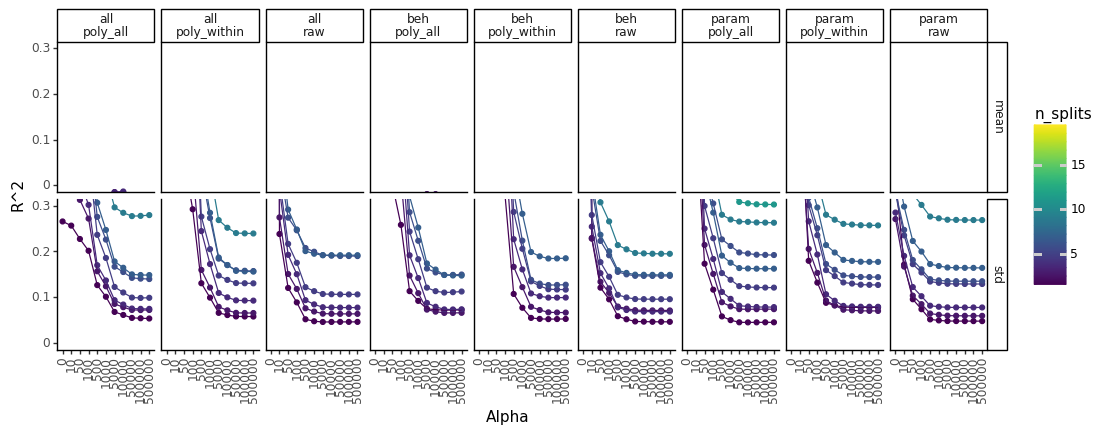

<ggplot: (132333238754)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 12 x 4 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5_RepeatGridSearchCV_PreciseYrs_adults_only.png


In [20]:
# Get data
gridder_long = make_gridder_long(all_gridders)

# Plot
gg.options.figure_size = (12, 4)
g = (gg.ggplot(
    gridder_long,
    gg.aes('factor(param_alpha)', 'score', color='n_splits', group='n_splits'))
     + gg.geom_point()
     + gg.geom_line()
     + gg.coord_cartesian(ylim=(0, 0.3))
     + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
     + gg.labs(x='Alpha', y='R^2')
     + gg.facet_grid('stat ~ data_sub + model_name')
    )
gg.options.figure_size = (5, 5)
print(g)
g.save(os.path.join(plot_save_path, '5_RepeatGridSearchCV_{}_{}.png'.format(predicted_feature, subset_age_group)))

In [21]:
best_scores = all_gridders.groupby(['model_name', 'data_sub']).aggregate('max').reset_index()[['model_name', 'data_sub', 'mean_test_score']]
best_models = all_gridders.loc[all_gridders.mean_test_score.isin(best_scores.mean_test_score.values)]
best_models = best_models[
    ['model_name', 'data_sub', 'param_alpha', 'n_splits', 'mean_test_score', 'std_test_score']  # , 'mean_train_score', 'std_train_score'
].reset_index(drop=True)
best_models

,model_name,data_sub,param_alpha,n_splits,mean_test_score,std_test_score
0,poly_all,all,10000,4,-0.013863,0.083628
1,poly_within,all,500000,2,-0.043306,0.057311
2,raw,all,500000,2,-0.034320,0.045598
3,poly_all,param,50000,2,-0.030965,0.044579
4,poly_within,param,500000,2,-0.043037,0.077251
5,raw,param,500000,2,-0.035320,0.047231
6,poly_all,beh,10000,3,-0.019642,0.068005
7,poly_within,beh,50000,2,-0.038915,0.051607
8,raw,beh,500000,2,-0.030973,0.045746


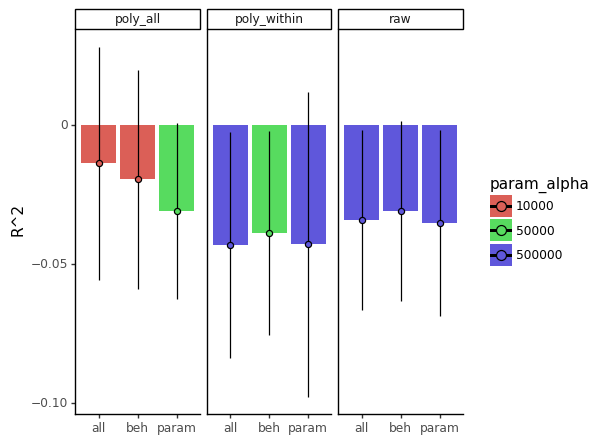

<ggplot: (132333207293)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 5 x 5 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5_R2AllModels_PreciseYrs_adults_only.png


In [22]:
best_models['ymax'] = best_models.mean_test_score + best_models.std_test_score / np.sqrt(best_models.n_splits)
best_models['ymin'] = best_models.mean_test_score - best_models.std_test_score / np.sqrt(best_models.n_splits)

g = (gg.ggplot(best_models, gg.aes('data_sub', 'mean_test_score', fill='param_alpha'))
     + gg.geom_bar(stat='identity')
     + gg.geom_pointrange(gg.aes(ymax='ymax', ymin='ymin'))
     + gg.labs(x='', y='R^2')
     + gg.facet_grid('~ model_name')
    )
print(g)
g.save(os.path.join(plot_save_path, '5_R2AllModels_{}_{}.png'.format(predicted_feature, subset_age_group)))

In [23]:
true_pred = pd.DataFrame()
coefs = pd.DataFrame()

for data_sub in np.unique(best_models.data_sub):
    for model_name in np.unique(best_models.model_name):
        print(data_sub, model_name)

        regr_dat, X, y = get_regr_data(all_data_z, data_sub=data_sub, model_name=model_name)

        # Fit model
        model_specs = best_models.loc[(best_models.model_name == model_name) & (best_models.data_sub == data_sub)]
        model = TransformedTargetRegressor(  # https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html
                    regressor=RidgeCV(
                        alphas=[model_specs.param_alpha.values[0]],
                        cv=RepeatedKFold(n_splits=model_specs.n_splits.values[0], n_repeats=n_repeats)),
        )
        _ = model.fit(X, y)

        # Get predictions
        y_pred = model.predict(X)
        tp_row = pd.DataFrame({'true': y, 'pred': y_pred})
        tp_row['model_name'] = model_name
        tp_row['data_sub'] = data_sub
        true_pred = true_pred.append(tp_row)
        
        # Get coefficients
        coefs_row = pd.DataFrame(
            model.regressor_.coef_, columns=['coef'], index=X.columns
        ).reset_index().rename(columns={'index': 'predictor'})
        coefs_row = beautify_coefs(coefs_row, model_name)
        coefs_row['model_name'] = model_name
        coefs_row['data_sub'] = data_sub
        coefs = coefs.append(coefs_row)
        
coefs = coefs.reset_index()
true_pred = true_pred.reset_index()

all poly_all
Number of features: 1952


NameError: name 'RepeatedKFold' is not defined

In [ ]:
g = (gg.ggplot(true_pred, gg.aes('true', 'pred'))
     + gg.geom_point(size=0.5)
     + gg.geom_smooth(color='red')
     + gg.labs(x='True {}'.format(predicted_feature), y='Predicted {}'.format(predicted_feature))
     + gg.facet_grid('model_name ~ data_sub')
    )
print(g)
g.save(os.path.join(plot_save_path, '5_TruePredicted{}_{}.png'.format(predicted_feature, subset_age_group)))

In [ ]:
gg.options.figure_size = (25, 10)

# Plot 1
g = (gg.ggplot(coefs.loc[coefs['pure_int_2'] == 'pure'], gg.aes('predictor_cat', 'coef', fill='category'))
 + gg.geom_bar(stat='identity')
 + gg.labs(x='', fill='')
#  + gg.theme(legend_position='none')
#  + gg.scale_x_discrete(limits=x_ticks)
 + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
#  + gg.facet_wrap('~ model_name + data_sub', scales='free')
 + gg.facet_grid('model_name ~ data_sub', scales='free_x')
)
print(g)
g.save(os.path.join(plot_save_path, '5_Predict{}_Ridge_MainEffects_{}.png'.format(predicted_feature, subset_age_group)))

In [ ]:
coefs['coef_abs'] = np.abs(coefs['coef'])
id_cols = ['model_name', 'data_sub']
n_coefs_per_group = 15

biggest_coefs = coefs.sort_values(
    id_cols, ascending=True) \
    .groupby(id_cols, sort=False) \
    .apply(lambda x: x.sort_values(['coef_abs'], ascending=False)) \
    .reset_index(drop=True) \
    .groupby(id_cols, sort=False) \
    .head(n_coefs_per_group) \
    .reset_index(drop=True) \
    .drop(columns='index')
biggest_coefs

In [ ]:
g_biggest = g
g.data = biggest_coefs
print(g)
g.save(os.path.join(plot_save_path, '5_Predict{}_Ridge_BiggestCoefs_{}.png'.format(predicted_feature, subset_age_group)))

## Old stuff

In [ ]:
# model = TransformedTargetRegressor(
#         regressor=RidgeCV(alphas=[50], cv=RepeatedKFold(n_splits=6, n_repeats=n_repeats)),
# )
# _ = model.fit(regr_X_raw, regr_y_raw)

In [ ]:
# y_pred = model.predict(regr_X_raw)
# true_pred = pd.DataFrame({'true': regr_y_raw, 'pred': y_pred})

In [ ]:
# coefs = pd.DataFrame(
#     model.regressor_.coef_, columns=['coef'], index=regr_X_raw.columns
# ).reset_index().rename(columns={'index': 'predictor'})
# coefs

In [ ]:
# gg.options.figure_size = (10, 5)
# g = (gg.ggplot(coefs, gg.aes('predictor', 'coef'))
#      + gg.geom_bar(stat='identity')
#      + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
#     )
# gg.options.figure_size = (5, 5)
# g

In [ ]:
# def plot_true_predicted(reg, regr_X, regr_y, name):
    
#     # Make DataFrame with true and predicted values
#     pred_y = reg.predict(regr_X)
#     linregr_true_pred = pd.DataFrame(np.array([np.array(regr_y), pred_y]).T, columns=('true_y', 'pred_y'))
    
#     # Calculate R^2
#     r2 = skmet.r2_score(regr_y, pred_y)

#     # Plot true against predicted
#     gg.options.figure_size = (6, 6)
#     g = (gg.ggplot(linregr_true_pred, gg.aes('true_y', 'pred_y'))
#          + gg.geom_point()
#          + gg.geom_smooth()
#          + gg.labs(x='True age', y='Predicted age')
#          + gg.geom_text(gg.aes(x=5, y=5, label=round(r2, 2)))
#     )
#     g.save(os.path.join(plot_save_path, '5_PredictAgeRidgeRegrPerf_{}.png'.format(name)))
#     print(g)
    
# # Plot ridge regression results on testing data
# plot_true_predicted(reg_raw, regr_X_raw_test, regr_y_raw_test, 'raw')
# plot_true_predicted(reg_raw_poly, poly_X_raw_test, regr_y_raw_test, 'raw_poly')
# plot_true_predicted(reg_pc, regr_X_pc_test, regr_y_pc_test, 'pc')

In [ ]:
# best_alpha = gridder_results.loc[gridder_results.mean_test_score == np.max(gridder_results.mean_test_score), 'alpha']

# g = (gg.ggplot(gridder_results, gg.aes('alpha', 'mean_test_score'))
#      + gg.geom_point()
#      + gg.geom_line()
#      + gg.geom_vline(xintercept=best_alpha, linetype='dotted')
#      + gg.geom_text(label=best_alpha)
#     )
# print(g)
# print("Best alpha: {}".format(best_alpha.values[0]))

In [ ]:
# def make_gridder_long(gridder_results):
    
#     gridder_long = pd.melt(gridder_results, id_vars='param_alpha', var_name='score_name', value_name='score')
#     gridder_long['stat'] = gridder_long['score_name'].apply(lambda x: x.split('_')[0])
#     gridder_long['train_test'] = gridder_long['score_name'].apply(lambda x: x.split('_')[1])
    
#     return gridder_long

# # Example use
# make_gridder_long(gridder_results)

In [ ]:
# def plot_gridder(gridder_results, n_splits, suf=''):
    
#     # Get best alpha and std at best alpha
#     gridder_long = make_gridder_long(gridder_results)
#     best_alpha = gridder_results.loc[gridder_results.mean_test_score == np.max(gridder_results.mean_test_score), 'param_alpha']
#     best_score = gridder_results.loc[gridder_results.mean_test_score == np.max(gridder_results.mean_test_score), 'mean_test_score']
#     std_best_alpha = gridder_results.loc[gridder_results.param_alpha == best_alpha.values[0], 'std_test_score']

#     # Plot
#     g = (gg.ggplot(gridder_long, gg.aes('param_alpha', 'score', color='train_test', group='train_test'))
#          + gg.geom_point()
#          + gg.geom_line()
#          + gg.geom_vline(xintercept=best_alpha.values[0], linetype='dotted')
#          + gg.geom_text(gg.aes(y=0.2), label=std_best_alpha.round(2))
#          + gg.geom_text(gg.aes(y=0.3), label=best_alpha)
#          + gg.geom_text(gg.aes(y=0.4), label=best_score.round(4))
#          + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
#          + gg.facet_wrap('~ stat')
#         )
#     g.save(os.path.join(plot_save_path, '5_RepeatGridSearchCV_nsplits{}{}.png'.format(n_splits, suf)))
    
#     return g

# # Example use
# plot_gridder(gridder_results, n_splits)

In [ ]:
def get_poly_task(pred):
    
    if ' ' in pred:  # Interaction between two tasks
        p0, p1 = pred.split(' ')
        task = p0[:2] + '_' + p1[:2]

    elif '^2' in pred:
        task = pred[:2] + '^2'

    else:  # Just one task
        task = pred[:2]
    
    return task

# # Example use
# get_poly_task(lin_reg_result_raw_poly['predictor'][5])

In [ ]:
def get_poly_pure_int_2(pred):
    
    if ' ' in pred:  # Interaction between two tasks
        pure_int_2 = 'interaction'

    elif '^2' in pred:
        pure_int_2 = '^2'

    else:  # Just one task
        pure_int_2 = 'pure'
        
    return pure_int_2

# # Example use
# get_poly_pure_int_2(lin_reg_result_raw_poly['predictor'][5])

In [ ]:
def beautify_lin_reg_result(lin_reg_result, name):
    
    if 'raw' in name:

        # Sort predictors by coefficient value (for plotting)
        lin_reg_result = lin_reg_result.sort_values(by='coef')
        lin_reg_result = lin_reg_result.reset_index(drop=True)
        lin_reg_result['predictor_cat'] = pd.Categorical(lin_reg_result['predictor'], categories=lin_reg_result['predictor'])

    elif name == 'pc':

        # Add columns
        lin_reg_result['predictor_cat'] = lin_reg_result['predictor'].apply(lambda x : int(x[2:]))

    if 'poly' not in name:
        lin_reg_result['task'] = lin_reg_result.predictor.apply(lambda x : x[:2])
        lin_reg_result['category'] = lin_reg_result['predictor'].apply(name_from_index, names=category_cols)
    else:
        lin_reg_result['category'] = lin_reg_result['predictor'].apply(get_poly_task)
        lin_reg_result['task'] = lin_reg_result['predictor'].apply(get_poly_pure_int_2)

    
    return lin_reg_result

# # Example use
# beautify_lin_reg_result(lin_reg_result_raw, 'raw')

In [ ]:
def gridsearch_best_alpha(regr_X, regr_y):
    
    tuned_parameters = [{
        'alpha': [0, 0.2, 0.5, 1, 2, 5, 10, 50, 100, 150, 180, 200, 230, 280, 300, 400, 500, 1000, 2000, 5000, 10000, 20000],
        'max_iter': [1e5]
    }]

    # Perform grid search
    ridge_grid = GridSearchCV(
        Ridge(), tuned_parameters,
        scoring=['r2', 'neg_mean_squared_error'], cv=5,
        iid=False, return_train_score=False, refit=False
    )
    ridge_best = ridge_grid.fit(regr_X, regr_y)
    
    # Get best alpha
    gridserach_results = pd.DataFrame(ridge_best.cv_results_).sort_values(by='rank_test_r2')
    best_gridsearch_alpha = gridserach_results.loc[gridserach_results['rank_test_r2'] == 1, 'param_alpha'].values[0]
    
    return gridserach_results, best_gridsearch_alpha

# Use
gridserach_results_raw, best_gridsearch_alpha_raw = gridsearch_best_alpha(regr_X_raw, regr_y_raw)
gridserach_results_pc, best_gridsearch_alpha_pc = gridsearch_best_alpha(regr_X_pc, regr_y_pc)
gridserach_results_raw_poly, best_gridsearch_alpha_raw_poly = gridsearch_best_alpha(poly_X_raw, regr_y_raw)
print("Best alpha (raw): {}; best alpha (PCs): {}; best alpha (raw poly): {}".format(
    best_gridsearch_alpha_raw, best_gridsearch_alpha_pc, best_gridsearch_alpha_raw_poly))

In [ ]:
# Split in train and test
regr_X_raw_train, regr_X_raw_test, regr_y_raw_train, regr_y_raw_test = skmod.train_test_split(
    regr_X_raw, regr_y_raw, test_size=0.33)

regr_X_pc_train, regr_X_pc_test, regr_y_pc_train, regr_y_pc_test = skmod.train_test_split(
    regr_X_pc, regr_y_pc, test_size=0.33)

poly_X_raw_train, poly_X_raw_test, poly_y_raw_train, poly_y_raw_test = skmod.train_test_split(
    poly_X_raw, regr_y_raw, test_size=0.33)

In [ ]:
# # from sklearn import metrics
# scores = cross_val_score(
#     clf, X, y, cv=5, scoring='f1_macro')
# scores
#
# -> should do https://scikit-learn.org/stable/modules/cross_validation.html, but we don't have enough data

In [ ]:
def run_ridge_regression(best_gridsearch_alpha, regr_X, regr_y, name):
    
    reg = sklin.Ridge(alpha=best_gridsearch_alpha).fit(regr_X, regr_y)

    lin_reg_result = pd.DataFrame(
        reg.coef_, [c for c in regr_X.columns if c != predicted_feature]).reset_index().rename(
        columns={'index': 'predictor', 0: 'coef'})
    lin_reg_result = beautify_lin_reg_result(lin_reg_result, name)
    
    return reg, lin_reg_result

# Run ridge regression on training data
reg_raw, lin_reg_result_raw = run_ridge_regression(best_gridsearch_alpha_raw, regr_X_raw_train, regr_y_raw_train, 'raw')
reg_raw_poly, lin_reg_result_raw_poly = run_ridge_regression(best_gridsearch_alpha_raw_poly, poly_X_raw_train, poly_y_raw_train, 'raw_poly')
reg_pc, lin_reg_result_pc = run_ridge_regression(best_gridsearch_alpha_pc, regr_X_pc_train, regr_y_pc_train, 'pc')

In [ ]:
def plot_true_predicted(reg, regr_X, regr_y, name):
    
    # Make DataFrame with true and predicted values
    pred_y = reg.predict(regr_X)
    linregr_true_pred = pd.DataFrame(np.array([np.array(regr_y), pred_y]).T, columns=('true_y', 'pred_y'))
    
    # Calculate R^2
    r2 = skmet.r2_score(regr_y, pred_y)

    # Plot true against predicted
    gg.options.figure_size = (6, 6)
    g = (gg.ggplot(linregr_true_pred, gg.aes('true_y', 'pred_y'))
         + gg.geom_point()
         + gg.geom_smooth()
         + gg.labs(x='True age', y='Predicted age')
         + gg.geom_text(gg.aes(x=5, y=5, label=round(r2, 2)))
    )
    g.save(os.path.join(plot_save_path, '5_PredictAgeRidgeRegrPerf_{}_{}.png'.format(name, subset_age_group)))
    print(g)
    
# Plot ridge regression results on testing data
plot_true_predicted(reg_raw, regr_X_raw_test, regr_y_raw_test, 'raw')
plot_true_predicted(reg_raw_poly, poly_X_raw_test, regr_y_raw_test, 'raw_poly')
plot_true_predicted(reg_pc, regr_X_pc_test, regr_y_pc_test, 'pc')

In [ ]:
def plot_coefs(lin_reg_result, gridsearch_alpha, name):
    
    gg.options.figure_size = (18, 6)
    
    # Plot 1
    g = (gg.ggplot(lin_reg_result, gg.aes('predictor_cat', 'coef', fill='task'))
     + gg.geom_point()
     + gg.geom_bar(stat='identity')
     + gg.labs(x='', fill='')
     + gg.theme(axis_text_x=gg.element_text(rotation=45, hjust=1))
     + gg.geom_text(gg.aes(x=2, y=0.1, label=gridsearch_alpha))
    )
    g.save(os.path.join(plot_save_path, '5_PredictAgeRidgeRegr_{}_{}.png'.format(name, subset_age_group)))
#     print(g)

    # Plot 2
    g2 = g + gg.aes(fill='category') + gg.facet_grid('~ task', scales='free_x')
    g2
    g2.save(os.path.join(plot_save_path, '5_PredictAgeRidgeRegr_ByTask_{}_{}.png'.format(name, subset_age_group)))
    
    return g2
    
# Plot coefficients of ridge regression
plot_coefs(lin_reg_result_raw, best_gridsearch_alpha_raw, 'raw')
plot_coefs(lin_reg_result_raw_poly, best_gridsearch_alpha_raw_poly, 'raw_poly')
sub_dat = lin_reg_result_raw_poly.loc[
    ((lin_reg_result_raw_poly.coef > 0.05).astype(int) + (lin_reg_result_raw_poly.coef < -0.05).astype(int)) > 0]
print(plot_coefs(sub_dat, best_gridsearch_alpha_raw_poly, 'raw_poly_sub'))
plot_coefs(lin_reg_result_pc, best_gridsearch_alpha_pc, 'pc')

# SVM

In [ ]:
all_data_z[param_cols_by_task]

In [ ]:
X, y

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV

x_params = [p for p in param_cols_by_task if 'bf' not in p]
y_param = 'bf_nalpha'  # 'bf_alpha'
print(y_param, '~', x_params)

X = all_data_z[x_params]
y = all_data_z['bf_alpha']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

svr = svm.SVR(kernel='poly', C=1e4, gamma='scale', degree=3, epsilon=.1, verbose=True)
svr_fit = svr.fit(X_train, y_train)
y_train_pred = svr_fit.predict(X_train)
y_test_pred = svr_fit.predict(X_test)

print("Train score: {}".format(svr.score(X_train, y_train)))
print("Test score: {}".format(svr.score(X_test, y_test)))
print(cross_val_score(svr, X_test, y_test, cv=5))
print(cross_val_score(svr, X_test, y_test, cv=LeaveOneOut()))

plt.plot(y_train, y_train_pred, '.')
plt.plot(y_test, y_test_pred, '.')

In [ ]:
tuned_parameters = [
    {'kernel': ['rbf', 'poly'],
     'C': [1e-1, 1e1, 1e2, 1e3, 1e4],
     'gamma': [1e-5, 1e-4, 1e-4, 1e-3, 1e-2, 1e-1]}]

clf = GridSearchCV(svm.SVR(), tuned_parameters, scoring='r2', cv=2, iid=False, return_train_score=False)
clf_fit = clf.fit(X, y)
# print(pd.DataFrame(clf_fit.cv_results_).sort_values(by='rank_test_score').head())

# clf = GridSearchCV(svm.SVR(), tuned_parameters, scoring='explained_variance', cv=2, iid=False, return_train_score=False)
# clf_fit = clf.fit(X_train, y_train)
# print(pd.DataFrame(clf_fit.cv_results_).sort_values(by='rank_test_score').head())
clf_fit.best_params_

In [ ]:

svr = svm.SVR(C=clf_fit.best_params_['C'], gamma=clf_fit.best_params_['gamma'], kernel=clf_fit.best_params_['kernel'])
svr_fit = svr.fit(X_train, y_train)
y_train_pred = svr_fit.predict(X_train)
y_test_pred = svr_fit.predict(X_test)

print("Train score: {}".format(svr.score(X_train, y_train)))
print("Test score: {}".format(svr.score(X_test, y_test)))
print(cross_val_score(svr, X_test, y_test, cv=5))
print(cross_val_score(svr, X_test, y_test, cv=LeaveOneOut()))

plt.plot(y_train, y_train_pred, '.')
plt.plot(y_test, y_test_pred, '.')

In [ ]:
from sklearn.model_selection import GridSearchCV

# param_grid = {'polynomialfeatures__degree': np.arange(21),
#               'linearregression__fit_intercept': [True, False],
#               'linearregression__normalize': [True, False]}

# grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)



tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
scores = ['precision', 'recall']

clf = GridSearchCV(
    svm.SVC(), tuned_parameters, scoring=scores[0]
)
clf.fit(X_train, y_train)

In [ ]:
# import numpy as np
# from sklearn.svm import SVR
# import matplotlib.pyplot as plt
from sklearn import svm

# #############################################################################
# Generate sample data
X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()

# #############################################################################
# Add noise to targets
# y[::5] += 3 * (0.5 - np.random.rand(8))
y += 0.5 - np.random.rand(len(X))

# #############################################################################
# Fit regression model
svr_rbf = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = svm.SVR(kernel='linear', C=100, gamma='auto')
svr_poly = svm.SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)

# #############################################################################
# Look at the results
lw = 2

svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ['RBF', 'Linear', 'Polynomial']
model_color = ['m', 'c', 'g']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10), sharey=True)
for ix, svr in enumerate(svrs):
    axes[ix].plot(X, svr.fit(X, y).predict(X), color=model_color[ix], lw=lw,
                  label='{} model'.format(kernel_label[ix]))
    axes[ix].scatter(X[svr.support_], y[svr.support_], facecolor="none",
                     edgecolor=model_color[ix], s=50,
                     label='{} support vectors'.format(kernel_label[ix]))
    axes[ix].scatter(X[np.setdiff1d(np.arange(len(X)), svr.support_)],
                     y[np.setdiff1d(np.arange(len(X)), svr.support_)],
                     facecolor="none", edgecolor="k", s=50,
                     label='other training data')
    axes[ix].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
                    ncol=1, fancybox=True, shadow=True)

fig.text(0.5, 0.04, 'data', ha='center', va='center')
fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
fig.suptitle("Support Vector Regression", fontsize=14)
plt.show()

In [ ]:
# get support vectors
clf.support_vectors_

# get indices of support vectors
clf.support_

# get number of support vectors for each class
clf.n_support_

## PLS

In [ ]:
from sklearn.cross_decomposition import PLSRegression
X = [[0., 0., 1.], [1.,0.,0.], [2.,2.,2.], [2.,5.,4.]]
Y = [[0.1, -0.2], [0.9, 1.1], [6.2, 5.9], [11.9, 12.3]]
pls2 = PLSRegression(n_components=2)
pls2.fit(X, Y)

Y_pred = pls2.predict(X)
Y_pred, Y
plt.plot(np.array(Y)[:,0], np.array(Y_pred)[:,0])

In [ ]:
x_params = [p for p in param_cols_by_task if 'bf' not in p]
y_params = [p for p in param_cols_by_task if 'bf' in p]
len(x_params)

In [ ]:
pls = PLSRegression(n_components=14)
pls.fit(all_data_z[x_params], all_data_z[y_params])

pred = pls.predict(all_data_z[x_params])
pls.score(all_data_z[x_params], all_data_z[y_params])  # R^2 of self.predict(X) wrt. y.

In [ ]:
pred = pd.DataFrame(pred, columns=y_params)
pred_l = pred.melt(var_name='param_name', value_name='param_value').reset_index()
true_l = all_data_z[y_params].melt(var_name='param_name', value_name='param_value').reset_index()
# dat = pd.merge(pred, all_data_z[y_params], left_index=True, right_index=True, suffixes=['_pred', '_true'])
# dat
dat_l = pd.merge(pred_l, true_l, on=['param_name', 'index'], suffixes=['_pred', '_true'])
dat_l

In [ ]:
(gg.ggplot(dat_l, gg.aes('param_value_pred', 'param_value_true', color='param_name'))
 + gg.geom_point(alpha=0.5)
 + gg.geom_smooth(color='black')
 + gg.facet_wrap('~ param_name')
)

In [ ]:
# true_pred = pd.DataFrame()
# coefs = pd.DataFrame()

# for model_name in np.unique(best_models.model_name):
#     for data_sub in np.unique(best_models.data_sub):
        
#         # PROBLEM: NEEDS TO BE INTEGRATED INTO UPPER LOOP BECAUSE I'M NOT SUBSETTING DATA HERE
    
#         # Get data
#         if model_name == 'raw':
#             X, y = regr_X_raw.copy(), regr_y_raw.copy()
#         elif model_name == 'poly_all':
#             X, y = poly_X_all.copy(), regr_y_raw.copy()
#         elif model_name == 'poly_within':
#             X, y = poly_X_within.copy(), regr_y_raw.copy()

#         # Fit model
#         model_specs = best_models.loc[
#             (best_models.model_name == model_name) & (best_models.data_sub == data_sub)]
#         model = TransformedTargetRegressor(  # https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html
#                 regressor=RidgeCV(
#                     alphas=[model_specs.param_alpha.values[0]],
#                     cv=RepeatedKFold(n_splits=model_specs.n_splits.values[0], n_repeats=n_repeats)),
#         )
#         _ = model.fit(X, y)

#         # Get predictions
#         y_pred = model.predict(X)
#         tp_row = pd.DataFrame({'true': y, 'pred': y_pred})
#         print(y[:5], y_pred[:5])
#         tp_row['model_name'] = model_name
#         tp_row['data_sub'] = data_sub
#         true_pred = true_pred.append(tp_row)
        
# #         print(plot_true_predicted(true_pred, '_'.join([model_name, data_sub])))

#         # Get coefficients
#         coefs_row = pd.DataFrame(
#             model.regressor_.coef_, columns=['coef'], index=X.columns
#         ).reset_index().rename(columns={'index': 'predictor'})
#         coefs_row = beautify_coefs(coefs_row, model_name)
#         coefs_row['model_name'] = model_name
#         coefs_row['data_sub'] = data_sub
#         coefs = coefs.append(coefs_row)

# #         print(plot_coefs(coefs, model_name))
# #         sub_dat = pd.concat([coefs.head(20), coefs.tail(20)])
# #         print(plot_coefs(sub_dat, model_name + '_sub'))

# true_pred
# coefs

In [ ]:
# if gridder_source == 'make':
    
#     all_gridders = pd.DataFrame()
#     for data_sub in ['param', 'beh', 'all']:
#         print("Data: {}         ".format(data_sub))

#         # Get raw regression data
#         param_cols = list(set([c for c in all_data_z.columns for p in param_names if p in c]))
#         beh_cols = list(set([c for c in all_data_z.columns if c not in param_cols]))

#         if data_sub == 'all':
#             regr_dat_raw, regr_X_raw, regr_y_raw = get_regr_data('raw', all_data_z=all_data_z)
#         elif data_sub == 'param':
#             regr_dat_raw, regr_X_raw, regr_y_raw = get_regr_data('raw', all_data_z=all_data_z[extended_ages_cols + param_cols])
#         elif data_sub == 'beh':
#             regr_dat_raw, regr_X_raw, regr_y_raw = get_regr_data('raw', all_data_z=all_data_z[beh_cols])
#         else:
#             raise ValueError('data_sub must be "all", "param", or "beh".')

#         # Get polynomial features
#         poly_X_all = get_poly_regr_data(regr_X_raw, 'all')
#         poly_X_within = get_poly_regr_data(regr_X_raw, 'within_tasks')
#         print('Number of polynomial features: {}'.format(poly_X_all.shape[1]))

#         for model_name in regr_model_names:
#             print("Model: {}        ".format(model_name))

#             # Get raw / polynomial data
#             if model_name == 'raw':
#                 X, y = regr_X_raw.copy(), regr_y_raw.copy()
#             elif model_name == 'poly_all':
#                 X, y = poly_X_all.copy(), regr_y_raw.copy()
#             elif model_name == 'poly_within':
#                 X, y = poly_X_within.copy(), regr_y_raw.copy()
#             else:
#                 raise ValueError('model_name must be "poly_all", "poly_within", or "raw".')

#             # Fit gridder thing to get best hyper-parameters
#             for i, n_splits in enumerate(n_splitss):
#                 print("{}/{} splits".format(i, len(n_splitss)), end='\r')

#                 gridder = RepeatableGridSearchCV(model, param_grid, n_repeats=n_repeats, n_splits=n_splits, scoring=scoring)
#                 gridder.fit(X, y)

#                 gridder_results = make_gridder_pd(gridder)
#                 gridder_results['data_sub'] = data_sub
#                 gridder_results['model_name'] = model_name
#                 gridder_results['n_splits'] = n_splits
#                 all_gridders = all_gridders.append(gridder_results)

#     # Save as csv
#     all_gridders.to_csv(gridder_path)

# elif gridder_source == 'load':
    
#     # Load csv
#     all_gridders = pd.read_csv(gridder_path, index_col=0)    
    
# all_gridders